# Transfer learning e ajuste fino de um modelo

Neste exemplo, aprenderemos como classificar imagens de cães e gatos usando aprendizagem por transferência a partir de uma rede pré-treinada.

Um modelo pré-treinado é uma rede salva que foi previamente treinada em um grande conjunto de dados, normalmente em uma tarefa de classificação de imagens. Podemos usar o modelo pré-treinado como ele está ou usar o aprendizado de transferência para personalizar esse modelo para uma determinada tarefa (similar).

A intuição por trás da aprendizagem por transferência para classificação de imagens é que se um modelo for treinado em um conjunto de dados grande e geral o suficiente, esse modelo servirá efetivamente como um modelo genérico do mundo visual. Nós podemos então aproveitar as características (i.e., mapas de características) aprendidas por esse modelo pré-treinado sem precisar começar do zero.

Neste notebook, iremos personalizar um modelo pré-treinado de duas formas:

1. Extração de características: Usaremos as representações aprendidas por uma rede anterior para extrair características significativas de novos exemplos. Nós simplesmente iremos adicionar um novo classificador (i.e., última camada com função softmax) sobre o modelo pré-treinado para que ele possa redirecionar as características aprendidas anteriormente para o novo conjunto de dados.
  + Nós não precisaremos retreinar o modelo inteiro. A rede convolucional pré-treinada já contém características que são genericamente úteis para classificar imagens. No entanto, a parte final de classificação do modelo pré-treinado é específica para a tarefa de classificação original e, posteriormente, específica para o conjunto de classes nas quais o modelo foi treinado.

2. Ajuste fino: descongelamos algumas das camadas superiores do modelo pré-treinado e treinamos em conjunto com a camada classificadora recém-adicionada. Isso nos permite “ajustar” as representações de características de ordem superior no modelo base para torná-las mais relevantes para a nova tarefa.

Seguiremos o fluxo de trabalho abaixo.

1. Examinar e compreender os dados
2. Construir um *pipeline* de pré-processamento de entrada
3. Criar o modelo
    * Carregar no modelo base pré-treinado (e pesos pré-treinados)
    * Empilhar as camadas de classificação por cima do modelo pré-treinado
4. Treinar o modelo
5. Avaliar o modelo

## Importando as bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Pré-processamento dos dados

### Baixando a base de dados

Neste exemplo, usaremos um conjunto de dados contendo milhares de imagens de cães e gatos. Vamos baixar e extrair um arquivo zip contendo as imagens e, em seguida, criar um `tf.data.Dataset` para treinamento e validação usando o utilitário `tf.keras.utils.image_dataset_from_directory`. Você pode aprender mais sobre como carregar imagens neste [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# Mini-batch size.
BATCH_SIZE = 32

# Image size.
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Exibindo as primeiras nove imagens e rótulos do conjunto de treinamento:

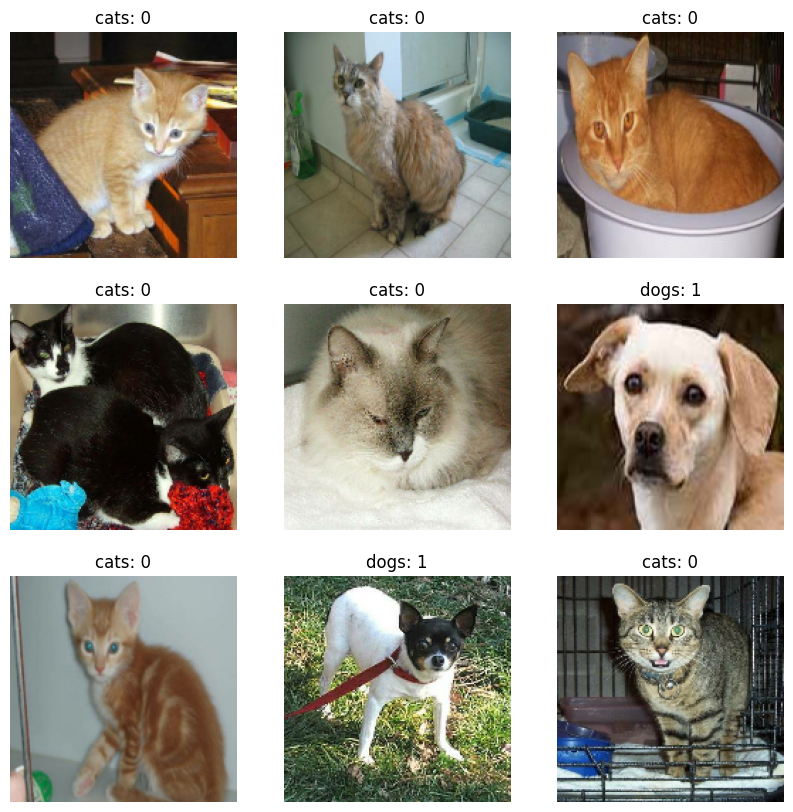

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]]+': '+str(int(labels[i])))
    plt.axis("off")

Como o conjunto de dados original não contém um conjunto de testes, nós criaremos um. Para fazer isso, determinamos quantos mini-lotes de dados estão disponíveis no conjunto de validação usando `tf.data.experimental.cardinality` e, em seguida, movemos 20% deles para um conjunto de teste.

In [42]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [43]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configurando o conjunto de dados para desempenho

Usamos a pré-busca (i.e., *prefetch*) em buffer para carregar imagens do disco sem bloquear a E/S. Para saber mais sobre esse método, consulte o guia [desempenho de dados](https://www.tensorflow.org/guide/data_performance).

In [44]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Usando data augmentation

Quando não temos um grande conjunto de dados de imagens, é uma boa prática introduzir artificialmente a diversidade de amostras aplicando transformações aleatórias, mas realistas, às imagens de treinamento, como rotação e inversão horizontal. Isso ajuda a expor o modelo a diferentes aspectos dos dados de treinamento e a reduzir o [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). Você pode aprender mais sobre aumento de dados neste [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [45]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Observação: Essas camadas ficam ativas apenas durante o treinamento, quando chamamos `Model.fit`. Elas ficam inativas quando o modelo é usado no modo de inferência em `Model.evaluate`, `Model.predict` ou `Model.call`.

Vamos aplicar essas camadas repetidamente na mesma imagem e ver o resultado.

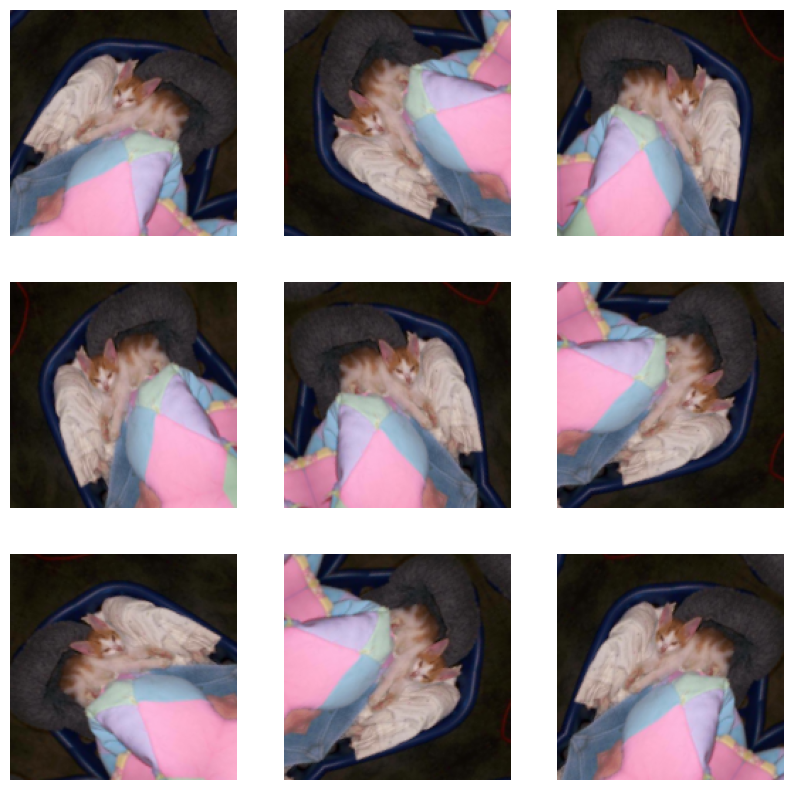

In [46]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Redimensionando valores de pixel

Em breve, faremos o download do modelo `tf.keras.applications.MobileNetV2` para usar como nosso modelo base. Este modelo espera valores de pixel em `[-1, 1]`, mas neste ponto, os valores de pixel em suas imagens estão em `[0, 255]`. Para redimensioná-los, usaremos o método de pré-processamento incluído no modelo.

In [47]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Observação: Alternativamente, podemos redimensionar os valores de pixel de `[0, 255]` para `[-1, 1]` usando a classe `tf.keras.layers.Rescaling`.

In [48]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Observação: Se estivermos usando outro modelo do módulo `tf.keras.applications`, devemos verificar a documentação da API para determinar se eles esperam pixels no intervalo de `[-1, 1]` ou `[0, 1]`, ou se devemos usar a função `preprocess_input` apropriada para o modelo.

## Criando o modelo base a partir das convnets pré-treinadas

Criaremos o modelo base a partir do modelo **MobileNetV2** desenvolvido pela Google. Ele é pré-treinado no conjunto de dados ImageNet, um grande conjunto de dados que consiste em 1,4 milhão de imagens e 1.000 classes. ImageNet é um conjunto de dados de treinamento em pesquisa com uma ampla variedade de categorias como `jaca` e `seringa`. Esta base de conhecimento nos ajudará a classificar cães e gatos em nosso conjunto de dados específico.

Primeiro, precisamos escolher qual camada do MobileNetV2 usaremos para extração de características. A última camada de classificação (no "topo", já que a maioria dos diagramas de modelos de aprendizado de máquina vão de baixo para cima) não é muito útil. Em vez disso, seguiremos a prática comum de depender da última camada antes da operação de achatamento. Esta camada é chamada de “camada gargalo”. As características da camada gargalo retêm mais generalidade em comparação com a camada final/superior.

Primeiro, instanciamos um modelo MobileNetV2 pré-carregado com pesos treinados na base de dados ImageNet. Ao especificar o argumento **include_top=False**, carregamos uma rede que não inclui as camadas de classificação na parte superior, o que é ideal para extração de características.

In [49]:
# Create the base model from the pre-trained model MobileNetV2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

Este extrator de características converte cada imagem `160x160x3` em um bloco de características `5x5x1280`. Vamos ver o que o modelo faz com um mini-lote de 32 imagens.

In [50]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Extração de características

Nesta etapa, iremos congelar a base convolucional do modelo criado na etapa anterior e usá-la como extrator de características. Além disso, adicionaremos um classificador sobre ela e o treinaremos.

### Congelando a base convolucional

É importante congelar a base convolucional antes de compilar e treinar o modelo. O congelamento (feito definindo-se `layer.trainable = False`) evita que os pesos de uma determinada camada sejam atualizados durante o treinamento. O MobileNetV2 tem muitas camadas, portanto, definir o atribuito `trainable` de todo o modelo como `False` irá congelar todas elas.

In [51]:
base_model.trainable = False

### Observação importante sobre camadas de BatchNormalization

Muitos modelos contêm camadas `tf.keras.layers.BatchNormalization`. Esta camada é um caso especial e devem ser tomadas precauções no contexto do ajuste fino, conforme mostrado mais adiante neste exemplo.

Quando definimos `layer.trainable = False`, a camada `BatchNormalization` será executada no modo de inferência e não atualizará suas estatísticas de média e variância.

Ao descongelar um modelo que contém camadas de `BatchNormalization` para fazer o ajuste fino, devemos manter as camadas de `BatchNormalization` no modo de inferência passando `training = False` ao chamar o modelo base. Caso contrário, as atualizações aplicadas aos pesos não treináveis destruirão o que o modelo aprendeu.

Para obter mais detalhes, consulte o [Guia de aprendizagem sobre transferência](https://www.tensorflow.org/guide/keras/transfer_learning).

In [52]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

### Adicionando uma camada de classificação

Para gerar predições a partir do bloco de características, tomamos a média das localizações espaciais `5x5`, usando uma camada `tf.keras.layers.GlobalAveragePooling2D` para converter as características em um único vetor de 1280 elementos por imagem.

In [53]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Aplicamos uma camada `tf.keras.layers.Dense` para converter essas características em uma única predição por imagem. Não precisamos de uma função de ativação aqui porque esta predição será tratada como um `logit`, ou seja, um valor bruto de predição (apenas as ativações). Os números positivos predizem a classe 1, os números negativos predizem a classe 0.

In [54]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Criamos um modelo encadeando as camadas de aumento de dados, reescalonamento, `base_model` e extrator de características usando a [API Keras Functional](https://www.tensorflow.org/guide/keras/funcional). Como mencionado anteriormente, fazemos `training=False` pois nosso modelo contém camadas de `BatchNormalization`.

In [55]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [56]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           

Os mais de 8 milhões de parâmetros no MobileNetV2 estão congelados, mas existem 1281 parâmetros _treináveis_ na camada densa. Eles são divididos entre dois objetos `tf.Variable`, os pesos e os biases.

In [57]:
len(model.trainable_variables)

2

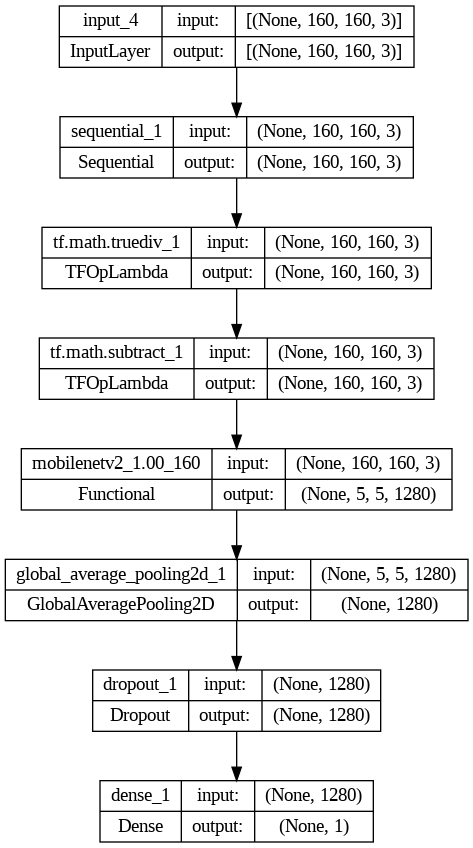

In [58]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Compilando o modelo

Compilamos o modelo antes de treiná-lo. Como existem duas classes, usamos a perda `tf.keras.losses.BinaryCrossentropy` com `from_logits=True`, pois o modelo fornece uma saída linear (i.e., última camada não tem função de ativação).

In [59]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

### Treinando o modelo

Vamos inicialmente verificar a acurácia do modelo sem nenhum treinamento no conjunto de validação.

In [60]:
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 2s 33ms/step - loss: 0.6627 - accuracy: 0.6139


In [61]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.66
initial accuracy: 0.61


Após treinarmos por 10 épocas, devemos ver uma acurácia de aproximadamente 96% no conjunto de validação.

In [62]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 7s 57ms/step - loss: 0.6132 - accuracy: 0.6645 - val_loss: 0.4418 - val_accuracy: 0.8354
Epoch 2/10
63/63 [==============================] - 4s 56ms/step - loss: 0.4775 - accuracy: 0.7850 - val_loss: 0.3253 - val_accuracy: 0.9097
Epoch 3/10
63/63 [==============================] - 4s 57ms/step - loss: 0.3898 - accuracy: 0.8325 - val_loss: 0.2637 - val_accuracy: 0.9369
Epoch 4/10
63/63 [==============================] - 5s 70ms/step - loss: 0.3235 - accuracy: 0.8815 - val_loss: 0.2186 - val_accuracy: 0.9493
Epoch 5/10
63/63 [==============================] - 4s 55ms/step - loss: 0.2798 - accuracy: 0.9030 - val_loss: 0.1904 - val_accuracy: 0.9579
Epoch 6/10
63/63 [==============================] - 4s 55ms/step - loss: 0.2620 - accuracy: 0.9045 - val_loss: 0.1721 - val_accuracy: 0.9530
Epoch 7/10
63/63 [==============================] - 5s 74ms/step - loss: 0.2387 - accuracy: 0.9155 - val_loss: 0.1490 - val_accuracy: 0.9616
Epoch 8/10
63

### Curvas de aprendizado

Vamos dar uma olhada nas curvas de aprendizado da acurácia/perda de treinamento e validação ao usar o modelo base MobileNetV2 como um extrator de características.

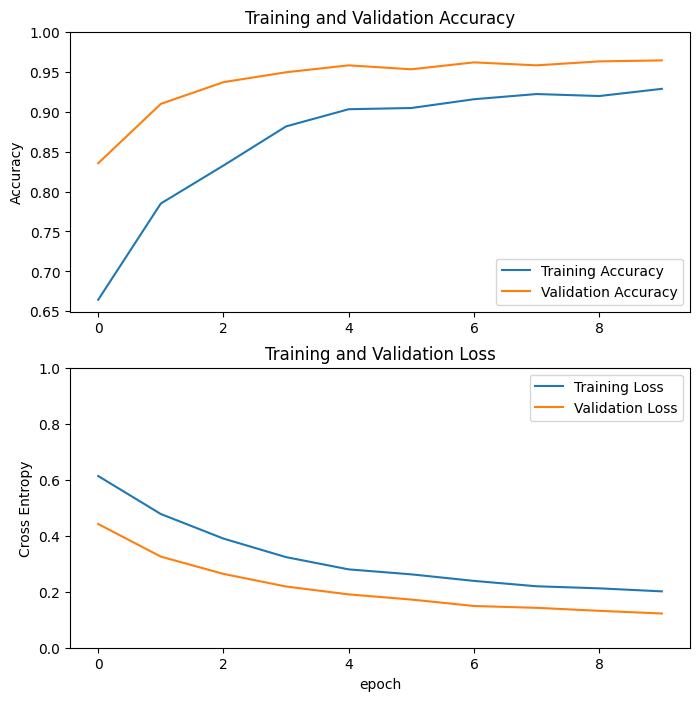

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Observação: Se você está se perguntando por que as métricas de validação são claramente melhores que as métricas de treinamento, o principal fator é porque camadas como `tf.keras.layers.BatchNormalization` e `tf.keras.layers.Dropout` afetam a acurácia durante o treinamento. Essas camadas são desligadas ao se calcular a perda de validação.

## Ajuste fino do modelo

No experimento de extração de características, nós treinamos apenas algumas camadas sobre um modelo base MobileNetV2. Os pesos da rede pré-treinada **não** foram atualizados durante o treinamento.

Uma maneira de aumentar ainda mais o desempenho é treinar (ou "ajustar") os pesos das camadas superiores do modelo pré-treinado junto com o treinamento do classificador que nós adicionamos. O processo de treinamento forçará os pesos a serem ajustados de mapas de características genéricas para características associadas especificamente ao conjunto de dados.

Observação: Isso só deve ser tentado depois de termos treinado o classificador com o modelo pré-treinado definido como não treinável. Se adicionarmos um classificador inicializado aleatoriamente em cima de um modelo pré-treinado e tentarmos treinar todas as camadas em conjunto, a magnitude das atualizações do gradiente será muito grande (devido aos pesos aleatórios do classificador) e o modelo pré-treinado irá esquecer o que aprendeu.

Além disso, devemos tentar ajustar um pequeno número de camadas superiores em vez de todo o modelo MobileNetV2. Na maioria das redes convolucionais, quanto mais alta uma camada, mais especializada ela é. As primeiras camadas aprendem características muito simples e genéricas que se generalizam para quase todos os tipos de imagens. À medida que avançamos, as características são cada vez mais específicas do conjunto de dados no qual o modelo foi treinado. O objetivo do ajuste fino é adaptar essas características especializadas para funcionarem com o novo conjunto de dados, em vez de substituir o aprendizado genérico.

### Descongelando as camadas superiores do modelo

Tudo o que precisamos fazer é descongelar o `base_model` e definir as camadas inferiores como não treináveis. Em seguida, devemos recompilar o modelo (necessário para que essas alterações tenham efeito) e retomar o treinamento.

In [64]:
base_model.trainable = True

In [65]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compilando o modelo

Como estamos treinando um modelo muito maior e desejamos reajustar os pesos pré-treinados, é importante utilizar uma taxa de aprendizado menor nesta fase. Caso contrário, o modelo poderá se ajustar muito rapidamente.

In [66]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [67]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           

In [68]:
len(model.trainable_variables)

56

### Continuando o treinamento do modelo

Esta etapa melhorará a acurácia do modelo em alguns pontos percentuais.

In [69]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

print('total_epochs:', total_epochs)

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

total_epochs: 20
Epoch 10/20
63/63 [==============================] - 15s 81ms/step - loss: 0.1614 - accuracy: 0.9350 - val_loss: 0.0627 - val_accuracy: 0.9765
Epoch 11/20
63/63 [==============================] - 4s 59ms/step - loss: 0.1175 - accuracy: 0.9545 - val_loss: 0.0541 - val_accuracy: 0.9827
Epoch 12/20
63/63 [==============================] - 5s 74ms/step - loss: 0.1159 - accuracy: 0.9515 - val_loss: 0.0615 - val_accuracy: 0.9790
Epoch 13/20
63/63 [==============================] - 4s 58ms/step - loss: 0.0912 - accuracy: 0.9645 - val_loss: 0.0467 - val_accuracy: 0.9851
Epoch 14/20
63/63 [==============================] - 5s 70ms/step - loss: 0.0921 - accuracy: 0.9665 - val_loss: 0.0410 - val_accuracy: 0.9864
Epoch 15/20
63/63 [==============================] - 5s 77ms/step - loss: 0.0828 - accuracy: 0.9675 - val_loss: 0.0383 - val_accuracy: 0.9827
Epoch 16/20
63/63 [==============================] - 4s 59ms/step - loss: 0.0815 - accuracy: 0.9645 - val_loss: 0.0463 - val_accur

Vamos dar uma olhada nas curvas de aprendizado da acurácia/perda de treinamento e validação ao ajustar as últimas camadas do modelo base MobileNetV2 e treinar o classificador sobre ele. A perda de validação é muito maior que a perda de treinamento, então podemos ter algum overfitting.

Podemos também ter overfitting, pois o novo conjunto de treinamento é relativamente pequeno e semelhante aos conjuntos de dados MobileNetV2 originais.

Após o ajuste fino, o modelo atinge quase 98% de acurácia no conjunto de validação.

In [70]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

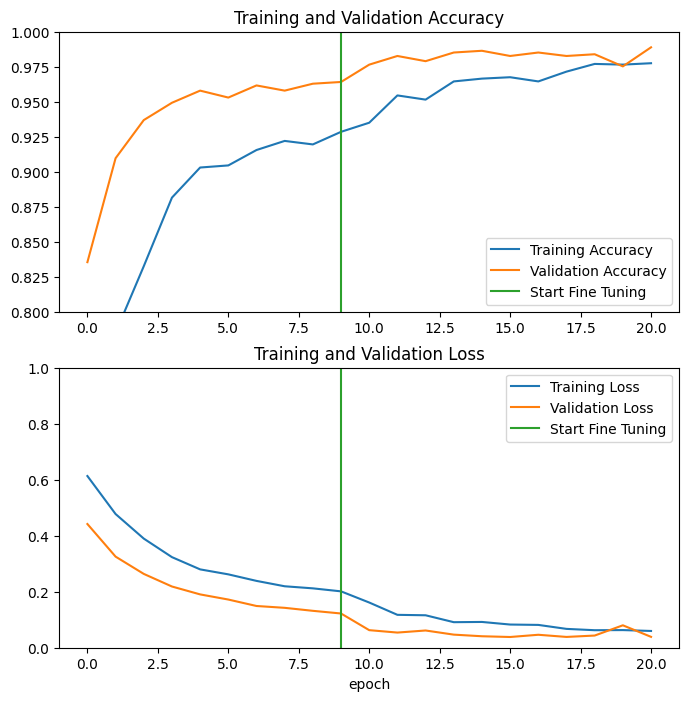

In [71]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Avaliação e predição

Finalmente, podemos verificar o desempenho do modelo em novos dados usando o conjunto de testes.

In [72]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 0s 40ms/step - loss: 0.0453 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


E agora estamos pronto para usar este modelo para prever se uma foto de um animal qualquer contém um gato ou um cachorro.

Predictions:
 [0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1 1 1 0]
Labels:
 [0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1 1 1 0]


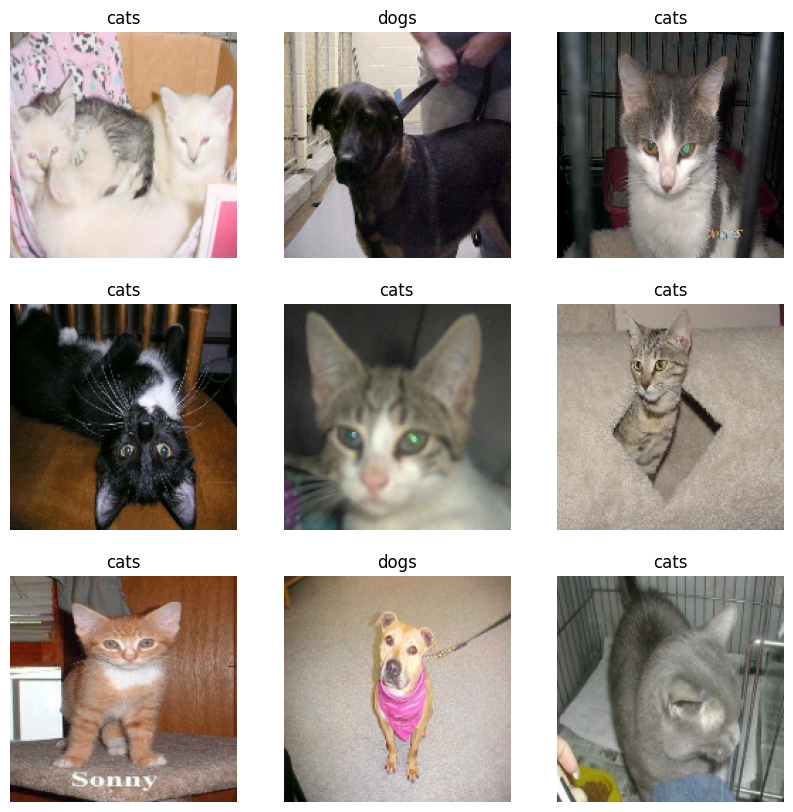

In [73]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Resumo

* **Uso de um modelo pré-treinado para extração de características**: ao trabalhar com um conjunto de dados pequeno, é uma prática comum aproveitar as características aprendidas por um modelo treinado em um conjunto de dados maior, mas no mesmo domínio. Isso é feito instanciando o modelo pré-treinado e adicionando um classificador (camada com ativação softmax) totalmente conectado no topo do modelo. O modelo pré-treinado fica “congelado” e apenas os pesos do classificador são atualizados durante o treinamento.
Nesse caso, a base convolucional extraiu todos os características associados a cada imagem e nós apenas treinamos um classificador que determina a classe da imagem dado aquele conjunto de características extraídas.

* **Ajustando um modelo pré-treinado**: para melhorar ainda mais o desempenho, pode-se querer redirecionar as camadas de nível superior dos modelos pré-treinados para o novo conjunto de dados por meio de ajuste fino.
Nesse caso, ajustamos os pesos do modelo de forma que ele aprendesse características de alto nível específicas do conjunto de dados. Essa técnica geralmente é recomendada quando o conjunto de dados de treinamento é grande e muito semelhante ao conjunto de dados original no qual o modelo pré-treinado foi treinado.

Para saber mais, visite o [Guia de aprendizagem sobre transferência](https://www.tensorflow.org/guide/keras/transfer_learning).